## **미니 프로젝트 A1** 잡음제거: k-NN의 활용 (p.162)
**목표**

이미지에 있는 잡음을 제거하는 일을 k-NN을 이용해 해보려고 한다. 이것은 잡음이 있는 이미지를 읽어 아래 그림과 같이 픽셀 개수만큼의 분류 결과를 내어 놓고, 이들을 모아 이미지를 구성하는 것이다. 이렇게 분류 결과를 여러 개 내어 놓는 것을 **다중 출력 분류**<sup>multi-output classification</sup>라고 한다.

### 1. 미리 준비할 것
이미지를 다루기 위해서 사이킷런에서 제공하는 **사이킷 이미지**<sup>scikit-image</sup>를 사용할 것이다. 사이킷 이미지와 관련한 정보는 아래 URL에서 얻을 수 있다.

https://scikit-image.org/

이 프로젝트에서는 이미지를 읽어 들이는 imread(), 이미지의 크기를 변경하는 resize() 함수를 사용하기 위해 아래와 같이 패키지 임포트를 실시한다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread         # 이미지를 읽어 들인다.
from skimage.transform import resize  # 이미지의 크기를 변경할 수 있다.

### 2. 이미지 읽어 들이기
우선 이미지를 읽고 배열에 차곡 차곡 넣어보자. 이미지가 저장된 폴더의 URL은 아래와 같다.

https://github.com/dknife/ML/raw/main/data/Proj1/40/

여기에 img01.jpg부터 img40.jpg까지의 파일이 잇다. 해당 URL에 파일 이름을 붙여서 사이킷 이미지의 io 서브 모듈에 있는 imread() 함수에 넘겨주면 된다. 여기에서 얻은 이미지 데이터가 img이다. 이 이미지들은 크기가 모두 제각각이므로 동일한 크기인 24X24로 변경하려고 한다. 이때 사용할 수 있는 함수가 사이킷 이미지의 transform 서브 모듈에 있는 resize() 함수이다. 여기에 크기를 바꾸려는 이미지 img, 원하는 이미지 크기 imgR, imgC를 넘겨주어 새로운 이미지를 얻는다. 그리고 각 이미지는 R, G, B 채널을 가지기 때문에 채널의 수를 3으로 지정했다. 생성된 이미지는 images 리스트의 append() 함수를 이용하여 차례로 담아 놓으면 된다.

In [2]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj1/40/'

imgR, imgC, channel = 24, 24, 3
images = []

for i in range(40):
  file = url + 'img{0:02d}.jpg'.format(i+1)   # 이미지 파일 이름을 만든다.
  img = imread(file)                          # 이미지를 읽는다.
  img = resize(img, (imgR, imgC ,channel))    # 이미지의 크기를 변경한다.
  images.append(img)                          # images 리스트에 담는다.

읽어들인 이미지들은 모두 40개이다. 이들을 확인하기 위해 화면에 이미지 배열을 그려주는 함수 plot_images()를 아래와 같이 구현한다. 이 함수는 맷플롯립의 서브플롯을 활용하여 구현되었다. 맷플롯립과 관련된 자료와 서적을 참고하면 이해하기 쉬울 것이다.

In [3]:
def plot_images(nRow, nCol, img):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol,nRow))
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1: axis = ax[j]
      else:         axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img[i * nCol + j])

이미지를 그리기 위해서는 plot_images()에 이미지 배열을 넘겨주면 된다. 이때 그림을 몇 행, 몇 열로 배열하여 그릴지를 지정한다. 40장은 다음과 같이 4행 10열에 배치하여 그릴 수 있다.

<Figure size 432x288 with 0 Axes>

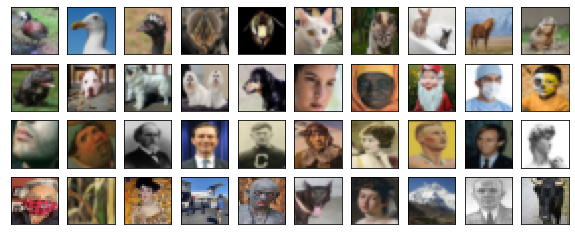

In [4]:
plot_images(4, 10, images)

### 3. 훈련용 데이터와 검증용 데이터 분리
기계학습은 데이터를 통해 훈련한 뒤에 얻은 동작 방법을 훈련에 사용한 적이 없는 새로운 모델에 적용하여 일반화 할 수 있다는 가정을 가지고 있다. 
그런데, **훈련 단계에서 일반화 능력을 검증하지 않는다면, 일반화 능력이 확인되지 않은 모델을 배포 혹은 사용하게 된다.
** 따라서 훈련 과정에서는 가지고 있는 데이터의 일부만을 사용하고, 학습된 내용의 일반화 능력은 검증용 데이터를 사용하여 확인하는 교차 검증 과정을 거친다. 
이러한 개념에 따라 우리는 확보한 데이터 가운데 30장의 이미지는 훈련용으로 사용하고, 나머지 10장의 이미지로 일반화 능력이 얼마나 되는지 확인해 보려고 한다.

아래와 같이 처음 30장은 훈련용 데이터 X로, 나머지 20장은 검증용 데이터 X_test로 만들어 보자.

<Figure size 432x288 with 0 Axes>

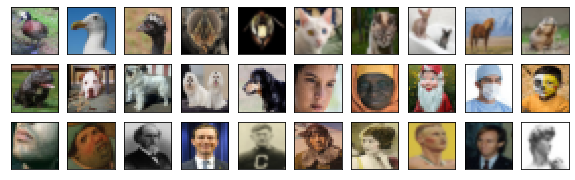

<Figure size 432x288 with 0 Axes>

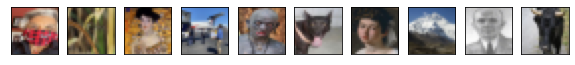

In [5]:
X = np.array(images[:30])
X_test = np.array(images[30:])
plot_images(3, 10, X)
plot_images(1, 10, X_test)

### 4. 입력 데이터 준비
훈련과 검증 단계를 위해 분리한 데이터는 모두 잡음이 없는 깨끗한 이미지로 정답 레이블로 사용될 것들이다.
훈련과정은 잡음이 섞인 입력 데이터를 가지고 이 정답 레이블을 만들어 내는 것이다.
따라서 훈련시 입력으로 사용할 수 있는 잡음이 섞인 이미지를 만들어 보자.
잡음은 넘파이를 이용하여 쉽게 만들 수 있는데, 잡음의 형식은 이미지 배열과 같은 차원을 가져야 하므로 (데이터 개수, 이미지 행, 이미지 열, 채널 수)의 차원으로 정규 분포를 따를 잡음을 생성한다.
그리고 이 잡음을 적절한 크기로 조절한 뒤 원래의 이미지 배열과 더하면 된다.

In [6]:
X_noisy = X + np.random.randn(len(X), imgR, imgC, channel)*0.1
X_noisy = np.clip(X_noisy, 0, 1)
X_test_noisy = X_test + np.random.randn(len(X_test), imgR, imgC, channel)*0.1
X_test_noisy = np.clip(X_test_noisy, 0, 1)

잡음이 추가된 이미지를 확인해 보자.

<Figure size 432x288 with 0 Axes>

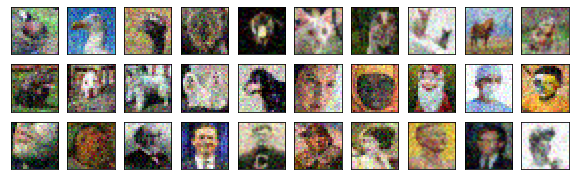

<Figure size 432x288 with 0 Axes>

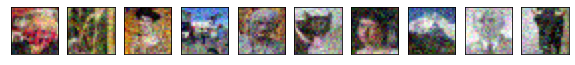

In [7]:
plot_images(3, 10, X_noisy)
plot_images(1, 10, X_test_noisy)

### 5. 분류기 입출력 데이터 형식에 맞추어 훈련하기
사이킷런의 k-NN 분류기는 이미지와 같은 2차원 이상의 데이터를 다루지 않고, 모든 입력을 1차원 벡터 데이터로 취급한다. 
따라서 입력 이미지 데이터 배열은 (이미지의 수, 이미지 픽셀의 수) 형태로 변형되어야 한다. 
이것은 넘파이의 resize() 함수로 할 수 있다.
이때 -1을 입력하면 해당 축의 크기로 나머지 축에 지정된 값에 따라 맞추어 자동으로 설정한다는 것이다.
따라서 훈련용 데이터의 잡음 이미지와 깨끗한 이미지는 다음과 같이 한 줄로 펼칠 수 있다. 
이때 분류기의 출력 레이블로 사용될 깨끗한 이미지 X_flat은 X를 변현하여 한 줄로 펼친 뒤에 255를 곱하고 있다. 이것은 넘파이로 읽은 이미지의 각 픽셀이 가진 0에서 1 사이의 부동소수점 값을 0에서 255 사이의 정수로 만들기 위한 것이다. k-NN 분류기의 출력은 클래스의 레이블이므로, 0에서 255 사이의 부호없는 정수로 바꾸는 것이다.

In [8]:
X_noisy_flat = X_noisy.reshape(-1, imgR*imgC*channel)
X_flat = np.array(X.reshape(-1, imgR*imgC*channel)*255, dtype=np.uint)

이제 잡음 이미지를 입력으로 깨긋한 이미지를 정답으로 분류기를 훈련시켜 보자.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_noisy_flat, X_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

얼마나 분류가 잘 이루어졌는지 잡음 이미지를 모델에 제공해 예측을 해보자. 매우 실망스러운 결과가 나타난다. 이것은 고작 30개의 이미지로 훈련해서는 제대로 된 픽셀 예측이 어렵다는 것을 의미한다.

<Figure size 432x288 with 0 Axes>

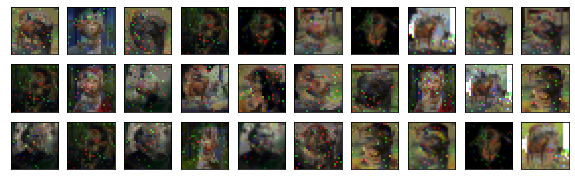

In [10]:
denoised_result = knn.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)

plot_images(3, 10, denoised_result)

### 6. 데이터를 증강하여 훈련 효과 높이기
부족한 데이터 문제를 극복하기 위해 우리가 가진 데이터를 변형하여 수를 늘려보자.
잡음을 추가하는 일을 반복하면 얼마든지 많은 수의 잡음 데이터를 만들 수 있다.
따라서 가지고 잇는 데이터에 임의의 잡음을 추가하는 일을 원하는 만큼 반복하여 결과를 모아 두자.
새롭게 만든 데이터에 사용될 정답 레이블은 원래의 정답 레이블을 아무런 조작 없이 쌓아나가면 된다.

아래 코드는 데이터를 증강해서 덧붙이는 횟수를 100으로 n_augmentation에 지정했다. 
그리고 잡음을 추가하여 얻은 이미지를 X_noisy_aug로 X에 있는 깨끗한 이미지를 0에서 255 사이의 정수를 갖는 출력용으로 변형한 레이블 데이터를 y_label로 지정했다. 
그리고, 증강 횟수만큼 반복하여 잡음 이미지 생성 및 덧붙이기와 레이블 덧붙이기를 하면 원래의 데이터보다 101배 더 많은 데이터를 준비할 수 있을 것이다. 출력을 통해 30장의 이미지가 3030장의 이미지로 늘어난 것을 확인할 수 있다.
넘파이의 append() 함수를 사용했으며, 이 함수는 (A, B, axis) 인자를 통해 A와 B를 결합한 배열을 반환한다. 이때 axis=0을 지정하면 행을 늘려가며 결합하고, axis=1을 지정하면 열을 늘려가며 병합한다.

In [11]:
n_augmentation = 100
X_noisy_aug = X + np.random.rand(len(X), imgR, imgC, channel) * 0.2
y_label = np.array(X * 255, dtype=np.uint)
y = y_label

print(X_noisy.shape)
for i in range(n_augmentation):
  noisy_data = X + np.random.randn(len(X), imgR, imgC, channel) * 0.2
  X_noisy_aug = np.append(X_noisy_aug, noisy_data, axis=0)
  y = np.append(y, y_label, axis = 0)

X_noisy_aug = np.clip(X_noisy_aug, 0, 1)
X_noisy_aug.shape, y.shape

(30, 24, 24, 3)


((3030, 24, 24, 3), (3030, 24, 24, 3))

슬라이싱을 이용하여 같은 데이터를 사용하여 잡음을 추가한 이미지가 얼마나 다양하게 생성되었는지 보자.

<Figure size 432x288 with 0 Axes>

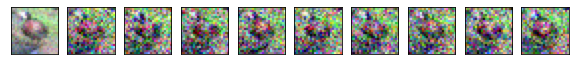

In [12]:
plot_images(1, 10, X_noisy_aug[0:300:30])

이제 늘어난 데이터로 훈련을 시켜보자. 차원을 1차원 벡터의 배열로 잘 변환한다.

In [13]:
X_noisy_aug_flat = X_noisy_aug.reshape(-1, imgR*imgC*channel)
y_flat = y.reshape(-1, imgR*imgC*channel)

knn.fit(X_noisy_aug_flat, y_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

얼마나 분류가 잘 이루어졌는지 다시 잡음 이미지를 모델에 제공해 예측을 해보자.
이번에는 잡음이 없는 이미지가 생성될 수 있도록 픽셀 단위 클래스 분석이 될 것이다.

<Figure size 432x288 with 0 Axes>

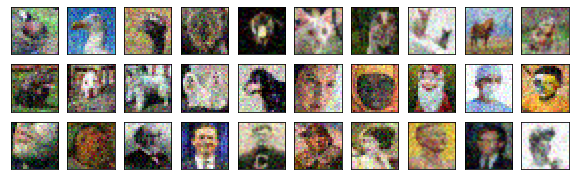

<Figure size 432x288 with 0 Axes>

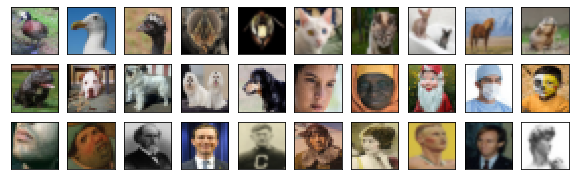

In [14]:
denoised_result = knn.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)

plot_images(3, 10, X_noisy)
plot_images(3, 10, denoised_result)

### 7. 검증 데이터로 일반화 능력을 살펴보자.
우선 잡음이 더욱 강하게 발생했을 때는 잘 찾는지 확인해 보자.
0에서 20 사이의 난수 정수를 하나 구한 뒤에 깨끗한 이미지가 담겨 잇는 X 배열에서 10개를 가지고 온다. 
그리고 이 이미지들에 표준편차 0.4의 강한 잡음으로 data를 만든다. 그리고 이 데이터를 k-NN 분리기에 적합한 차원으로 변형하여 data_flat에 담는다. 이 데이터를 이용하여 예측을 실시하는 코드는 아래와 같다. 결과로 얻은 배열을 이미지 형태로 다시 변형하자. 그리고 데이터와 예측 결과를 화면에 그려보자. 매우 심하게 잡음이 추가되었지만, 정답을 잘 찾고 있다.

<Figure size 432x288 with 0 Axes>

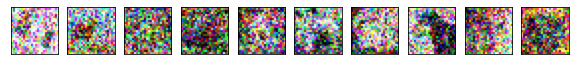

<Figure size 432x288 with 0 Axes>

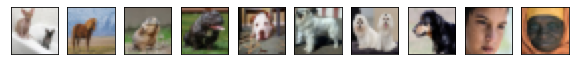

In [15]:
rndidx = np.random.randint(0, 20)
data = X[rndidx:rndidx+10] + np.random.randn(10, imgR, imgC, channel)*0.4
data = np.clip(data, 0, 1)
data_flat = data.reshape(-1, imgR*imgC*channel)

denoised = knn.predict(data_flat)
denoised = denoised.reshape(-1, imgR, imgC, channel)
denoised = np.clip(denoised, 0, 255)

plot_images(1, 10, data)
plot_images(1, 10, denoised)

이러한 예측 성능이 훈련에서 사용한 적이 없는 데이터에 대해서도 나타날까?
우리가 검증용으로 준비해 둔 데이터가 X_test이다. 여기에 잡음을 넣어 생성해 둔 데이터가 X_test_noisy였는데, 이것을 가지고 예측을 해 보자. 
비슷한 이미지를 만들어 내려고 하지만 훈련 과정에서 본 정답이 30개를 만복해서 만든 것뿐이기 때문에 만족스러운 결과가 나타나지 않는다.
이것은 우리의 일반화 능력이 그다지 높지 않다는 것을 의미한다.

<Figure size 432x288 with 0 Axes>

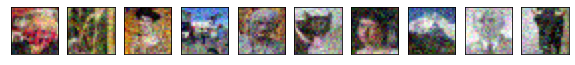

<Figure size 432x288 with 0 Axes>

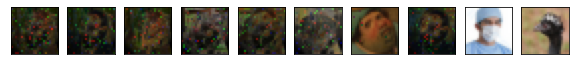

In [16]:
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

### 8. 데이터 증강으로 일반화 능력을 높여보자.
일반화 능력을 높이기 위해서는 데이터를 증강하는 것이 한 가지 방법이다.
앞서 우리는 잡음을 추가하는 일을 여러 번 반복함으로써 입력 데이터에 대해서는 증강을 해 보았다. 
그러나 출력 정답은 제한된 수의 데이터를 반복해서 사용했다.
이번에는 출력 이미지를 다양한 방법으로 왜곡시켜 정답 레이블을 증상시키고, 입력은 증강된 정답 레이블 정보에 잡음을 넣어서 생성해 보자.

이미지를 다양하게 변형하여 새로운 데이터를 만들어내는 도구로 케라스 API에 ImageDataGenerator 클래스가 있다. 
이 클래스는 다음과 같이 생성할 때 이미지이 회전, 확대축소, 기울이기, 상화좌우 반전과 관련된 선택 사항을 지정하여 원래의 이미지를 변형한 결과를 만들어내는 일을 한다.

In [17]:
### 이미지 데이터를 증강시키기 ###
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

이 클래스는 **반복자**<sup>iterator</sup>를 생성하여 이미지를 계속해서 생성할 수 있는데, 반복자는 다음과 같이 생성한다. 
ImageDataGenerator의 flow() 메서드에 원본 이미지를 데이터를 집어 넣어 생성한다. 
반복자는 next() 함수를 호출할 때마다 데이터를 반환한다.
우선 깨끗한 이미지를 담고 있는 X를 이용하여 처음 증강된 레이블 데이터를 담고 있을 y_aug를 만든다. 그리고 이 이미지가 데이터 증강에 사용될 원본 이미지가 된다. 이미지는 몇 개인지는 nData에 저장해둔다.

In [18]:
y_aug = X.reshape(-1, imgR, imgC, channel)
it = image_generator.flow(y_aug)
nData = y_aug.shape[0]

이를 이용하여 데이터 증강을 해 보자. 입력 데이터는 레이블 데이터 y_aug에 잡음을 섞어 X_aug로 만든다.

In [19]:
X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel) * 0.1

다음으로 실제 데이터 증강에 들어간다. 데이터를 증강시킬 횟수를 정해 반복하며, 이미지 생성기의 반복자가 가진 next()를 호출해 새로운 이미지를 만들어 낸다.
이것이 새로운 레이블 new_y가 되고, 새로운 입력 new_x는 여기에 잡음을 추가한다.
그리고 두 데이터를 원래의 레이블 y_aug, 입력 데이터 X_aug에 계속 덧붙여 나간다.

In [20]:
 n_augmentation = 500
 for _ in range(n_augmentation):
   new_y = it.next()
   new_X = new_y + np.random.randn(nData, imgR, imgC, channel) * 0.1
   y_aug = np.append(y_aug, new_y)
   X_aug = np.append(X_aug, new_X)

y_aug = np.array(y_aug*255, dtype=np.uint)
y_aug = y_aug.reshape(-1, imgR, imgC, channel)
X_aug = y_aug.reshape(-1, imgR, imgC, channel)

출력은 0에서 255, 입력은 0에서 1 사이의 값을 갖는 이미지인데, 잡음 등의 이유로 범위를 넘어서지 않도록 **클리핑**<sup>clipping</sup>을 하고, 화면 병형된 이미지들 일부를 그려 보자. 
다양한 모습으로 변형되어 데이터를 구성하고 있음을 확인할 수 잇다.

<Figure size 432x288 with 0 Axes>

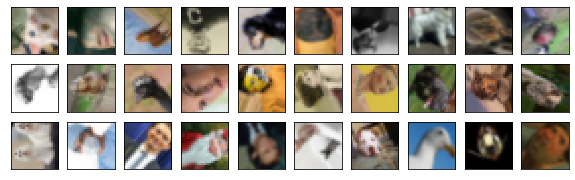

In [21]:
y_aug = np.clip(y_aug, 0, 255)
X_aug = np.clip(X_aug, 0, 1)

plot_images(3, 10, y_aug[30:])

### 9. 새로 학습하고 검증용 데이터 적용하기
증강된 데이터를 이용하여 학습을 새로 수행하자. 이때 이미지를 1차원으로 펼친다.

In [22]:
X_aug_flat = X_aug.reshape(-1, imgR*imgC*channel)
y_aug_flat = y_aug.reshape(-1, imgR*imgC*channel)
knn.fit(X_aug_flat, y_aug_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

이제 검증용 데이터를 모델에 입력하여 예측을 해 보자. 
검증데이터와 예측 결과를 화면에 출력하는 일도 해 보자.
완전히 새로운 데이터에 대해서는 답을 잘 찾지 못 한다.

<Figure size 432x288 with 0 Axes>

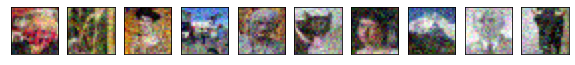

<Figure size 432x288 with 0 Axes>

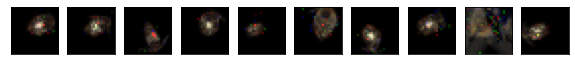

In [23]:
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised)

조금 나아진 것 같지만 일반화 능력을 높이기가 쉽지 않음을 알 수 있다. 
이번에는 강한 잡음을 추가한 이미지에서 잡음을 줄여 보자.
이 입력은 훈련에서 사용한 적이 없다. 
하지만 정답이 지금까지 봐 왔던 것과 유사한 것들이기 때문에 잡음이 많아도 답을 잘 찾는다.
이 프로젝트는 **차원 축소와 오토인코더를 다루는 11장을 마치고 더 나은 방법으로 개선**할 것이다.

<Figure size 432x288 with 0 Axes>

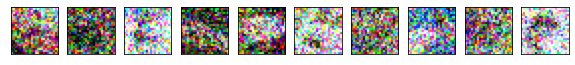

<Figure size 432x288 with 0 Axes>

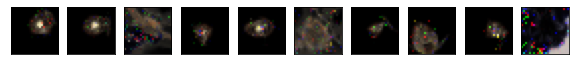

In [24]:
images = it.next()
testX = images + np.random.randn(nData, imgR, imgC, channel) * 0.4
testX = np.clip(testX, 0, 1)
denoised = knn.predict(testX.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, testX)
plot_images(1, 10, denoised)

위의 코드를 한 번 더 실행하면 새로운 데이터로 다시 잡음 제거를 실시한다. 여러 번 반복해볼 수 있다.

<Figure size 432x288 with 0 Axes>

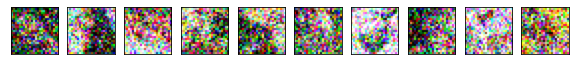

<Figure size 432x288 with 0 Axes>

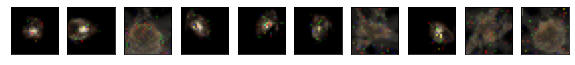

In [25]:
images = it.next()
testX = images + np.random.randn(nData, imgR, imgC, channel) * 0.4
testX = np.clip(testX, 0, 1)
denoised = knn.predict(testX.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1, 10, testX)
plot_images(1, 10, denoised)